<a href="https://colab.research.google.com/github/Vasudev-2308/agrobuddy_plant_disease/blob/main/Plant_Diease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

In [2]:
import numpy as np
import pandas as pd
import os 


len(os.listdir("/content/drive/MyDrive/PlantDisease/Dataset/train"))

38

In [3]:
import keras 

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions 

In [4]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3, horizontal_flip=True, preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train = train_datagen.flow_from_directory(directory="/content/drive/MyDrive/PlantDisease/Dataset/train", target_size=(256,256), batch_size=32)


valid = val_datagen.flow_from_directory("/content/drive/MyDrive/PlantDisease/Dataset/valid", target_size=(256,256), batch_size=32)

Found 70363 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [6]:
from keras.layers import Dense, Flatten
from keras.models import Model

In [7]:
#Base Model

base_model = VGG19(input_shape=(256,256,3), include_top=False)

base_model.summary()


80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [8]:
for layer in base_model.layers:
  layer.trainable = False

In [9]:
x = Flatten()(base_model.output)

x = Dense(units=38, activation='softmax')(x)

model = Model(base_model.input, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
# Early Stopping and Callbacks 


from keras.callbacks import ModelCheckpoint, EarlyStopping

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.01,patience=3, verbose=1)

#model Checkpoint 

modelCheckpoint = ModelCheckpoint("model_best.h5", save_best_only=True,monitor='val_accuracy', verbose=1)


callback = [earlyStopping, modelCheckpoint]



In [11]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
history = model.fit_generator(
    train, 
    steps_per_epoch=15, 
    epochs=50, 
    callbacks=callback, 
    validation_data=valid, verbose=1, validation_steps=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 29.9476 - accuracy: 0.1583
Epoch 1: val_accuracy improved from -inf to 0.32292, saving model to model_best.h5
15/15 [==============================] - 206s 13s/step - loss: 29.9476 - accuracy: 0.1583 - val_loss: 17.9440 - val_accuracy: 0.3229
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 17.3404 - accuracy: 0.3833
Epoch 2: val_accuracy improved from 0.32292 to 0.56875, saving model to model_best.h5
15/15 [==============================] - 201s 14s/step - loss: 17.3404 - accuracy: 0.3833 - val_loss: 11.5921 - val_accuracy: 0.5688
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 12.9917 - accuracy: 0.4750
Epoch 3: val_accuracy improved from 0.56875 to 0.63125, saving model to model_best.h5
15/15 [==============================] - 203s 14s/step - loss: 12.9917 - accuracy: 0.4750 - val_loss: 10.5613 - val_accuracy: 0.6313
Epoch 4/50
15/15 [==============================] - ETA: 0s -

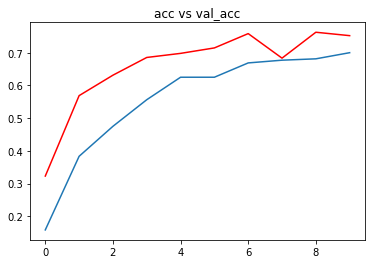

In [12]:
import matplotlib.pyplot as plt

h = history.history

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title('acc vs val_acc')

plt.show()

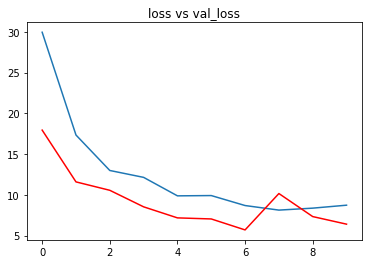

In [13]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title('loss vs val_loss')

plt.show()

In [14]:
#load best model 

from keras.models import load_model

trained_model = load_model("/content/model_best.h5")


In [15]:
disease_ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [16]:
def prediction(path):
  img = load_img(path, target_size=(256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis=0)

  pred = np.argmax(trained_model.predict(img))

  return (pred)

In [17]:
disease_index = prediction("/content/drive/MyDrive/PlantDisease/test/test/AppleScab2.JPG")

print(disease_ref[disease_index])

Apple___Apple_scab


In [18]:
import pickle


In [19]:
with open('plant_disease_detection_model.pkl', 'wb') as file_:
    pickle.dump(trained_model, file_)

INFO:tensorflow:Assets written to: ram://a8beee26-a683-41eb-abb4-accd50cca7a7/assets
